In [1]:
import copy
from collections import OrderedDict
import itertools
import math
import os

import torch
import torch.nn as nn
import torch.utils.data as data

from torchvision.datasets import MNIST
import torchvision.transforms as tf

import pyro
import pyro.nn as pynn
import pyro.distributions as dist
import pyro.infer.autoguide as ag
import pyro.contrib.easybnn as ezbnn
import pyro.contrib.easybnn.poutine as ez_poutine

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
NUM_TRAIN = 20
NUM_TEST = 121
TRAIN_DELTA = 4
TEST_DELTA = 6
OBSVERVATION_NOISE = 3.

YLIM = 100

In [3]:
x_train = 2 * TRAIN_DELTA * (torch.rand(NUM_TRAIN, 1) - 0.5)
y_train = x_train.pow(3) + OBSVERVATION_NOISE * torch.randn_like(x_train)

x_test = torch.linspace(-TEST_DELTA, TEST_DELTA, NUM_TEST).unsqueeze(-1)
y_test = x_test.pow(3)

In [4]:
def plot(pred_loc=None, pred_scale=None, ylim=YLIM):
    plt.scatter(x_train.numpy(), y_train.numpy())
    plt.plot(x_test, y_test)
    if pred_loc is not None:
        plt.plot(x_test, pred_loc)
    if pred_scale is not None:
        plt.fill_between(x_test.squeeze(),
                         pred_loc.sub(3 * pred_scale).squeeze(),
                         pred_loc.add(3 * pred_scale).squeeze(),
                         alpha=0.3)
    
    if ylim is not None:
        plt.ylim(-ylim, ylim)

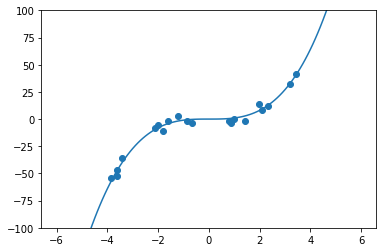

In [5]:
plot()

In [6]:
dataset = data.TensorDataset(x_train, y_train)
data_loader = data.DataLoader(dataset, batch_size=NUM_TRAIN // 2)

In [7]:
def build_net(num_inputs, num_units, num_outputs, num_layers=1):
    return nn.Sequential(nn.Linear(num_inputs, num_units), nn.ReLU(),
                         *list(itertools.chain.from_iterable([(nn.Linear(num_units, num_units), nn.ReLU())
                                                              for _ in range(num_layers)])),
                         nn.Linear(num_units, num_outputs))

In [8]:
def bayesianize(net, observation_model, prior=None, guide=None, **kwargs):
    if prior is None:
        prior = ezbnn.priors.IIDPrior(dist.Normal(0., 1.))
    if guide is None:
        guide = ezbnn.guides.ParameterwiseDiagonalNormal
    return ezbnn.BNN(net, prior, observation_model, guide, **kwargs)

In [9]:
reg_net = build_net(1, 100, 1, 1)
reg_observation_model = ezbnn.observation_models.HomoskedasticGaussian(scale=3.)
reg_bnn = bayesianize(reg_net, reg_observation_model, init_loc_fn=ezbnn.guides.init_to_normal_xavier)

In [10]:
reg_optim = pyro.optim.Adam({"lr": 1e-3})

In [11]:
pyro.clear_param_store()
with ez_poutine.local_reparameterization():
    svi = reg_bnn.fit(data_loader, reg_optim, 10000)

In [12]:
def plot_predictions(bnn, n):
    pred_loc, pred_scale = bnn.predict(x_test, n, aggregate=True)
    plot(pred_loc, pred_scale - OBSVERVATION_NOISE)

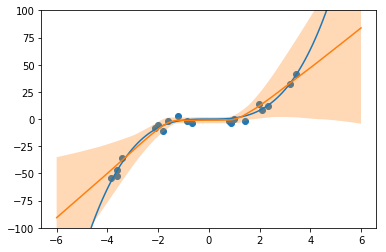

In [49]:
plot_predictions(reg_bnn, 25)
plt.savefig("reg_no_lr.png")

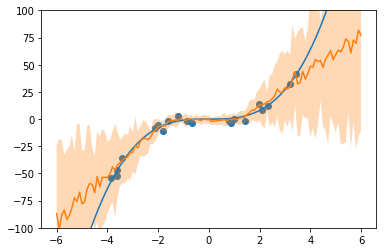

In [50]:
with ez_poutine.local_reparameterization():
    plot_predictions(reg_bnn, 25)
plt.savefig("reg_lr.png")

In [15]:
reg_bnn2 = bayesianize(reg_net, reg_observation_model, guide=ag.AutoLowRankMultivariateNormal, rank=10)
reg_optim2 = pyro.optim.Adam({"lr": 1e-3})

In [16]:
pyro.clear_param_store()
svi = reg_bnn2.fit(data_loader, reg_optim2, 10000)

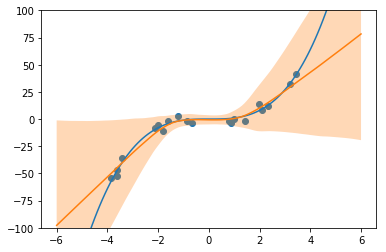

In [17]:
plot_predictions(reg_bnn2, 25)

In [18]:
nuts_bnn = bayesianize(reg_net, reg_observation_model, guide=pyro.infer.mcmc.NUTS, step_size=1e-3, max_tree_depth=6)

In [19]:
nuts_bnn.fit(data_loader, None, 10000)

Sample: 100%|██████████| 12000/12000 [1:02:14,  3.21it/s, step size=5.10e-03, acc. prob=0.870]


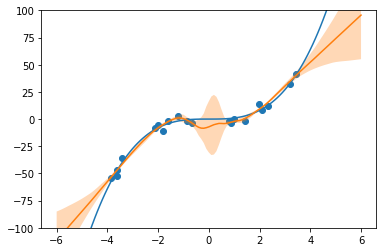

In [51]:
plot_predictions(nuts_bnn, 25)
plt.savefig("reg_nuts.png")

In [21]:
data_dir = os.environ.get("DATASETS_PATH", "./data")
flat_transform = tf.Compose([tf.ToTensor(), lambda img: img.flatten()])
mnist_train = MNIST(data_dir, train=True, download=True, transform=flat_transform)
mnist_test = MNIST(data_dir, train=False, transform=flat_transform)

In [22]:
mnist_train_loader = data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test_loader = data.DataLoader(mnist_test, batch_size=1000)

In [23]:
mnist_net = build_net(784, 200, 10, 2)
cat_observation_model = ezbnn.observation_models.Categorical()

In [31]:
pyro.clear_param_store()
lr_bnn = bayesianize(
    mnist_net,
    cat_observation_model,
    prior=ezbnn.priors.IIDPrior(dist.Normal(0., 1.)),  # LayerwiseNormalPrior("radford"),
)
optim = pyro.optim.Adam({"lr": 1e-3})
lr_elbos = []
with ez_poutine.local_reparameterization():
    svi = lr_bnn.fit(mnist_train_loader, optim, 50, callback=lambda b, i, e: lr_elbos.append(-e))

In [32]:
sum(100 * lr_bnn.evaluate(x, y, num_predictions=10)[0] for x, y in iter(mnist_test_loader)) / len(mnist_test_loader.sampler)

tensor(3.6500)

In [33]:
pyro.clear_param_store()
no_lr_bnn = bayesianize(
    mnist_net,
    cat_observation_model,
    prior=ezbnn.priors.IIDPrior(dist.Normal(0., 1.)),  # LayerwiseNormalPrior("radford"),
)
optim = pyro.optim.Adam({"lr": 1e-3})
no_lr_elbos = []
svi = no_lr_bnn.fit(mnist_train_loader, optim, 50, callback=lambda b, i, e: no_lr_elbos.append(-e))

In [34]:
sum(100 * no_lr_bnn.evaluate(x, y, num_predictions=10)[0] for x, y in mnist_test_loader) / len(mnist_test_loader.sampler)

tensor(2.8900)

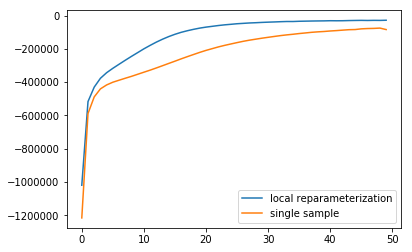

In [35]:
plt.plot(lr_elbos, label="local reparameterization")
plt.plot(no_lr_elbos, label="single sample")
plt.legend()

In [36]:
class Flatten(nn.Module):
    def __init__(self, start=1, end=-1):
        super().__init__()
        self.start = start
        self.end = end
        
    def forward(self, x):
        return x.flatten(self.start, self.end)

In [37]:
class LeNet(nn.Sequential):
    def __init__(self):
        modules = OrderedDict([
            ("Conv1", nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)),
            ("Nonl1", nn.ReLU(inplace=True)),
            ("Pool1", nn.MaxPool2d(2)),
            ("Conv2", nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)),
            ("Nonl2", nn.ReLU(inplace=True)),
            ("Pool2", nn.MaxPool2d(2)),
            ("Flatten", Flatten()),
            ("Dense1", nn.Linear(400, 84)),
            ("Nonl3", nn.ReLU(inplace=True)),
            ("Dense2", nn.Linear(84, 10))
        ])
        super().__init__(modules)

In [38]:
data_dir = os.environ.get("DATASETS_PATH", "./data")
img_transform = tf.ToTensor()

mnist_train = MNIST(data_dir, train=True, download=True, transform=img_transform)
mnist_test = MNIST(data_dir, train=False, transform=img_transform)

mnist_train_loader_img = data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test_loader_img = data.DataLoader(mnist_test, batch_size=1000)

In [39]:
lenet = LeNet()

In [40]:
def fit_bnn_mnist(bnn, num_epochs=25):
    def test():
        return sum(100 * bnn.evaluate(x, y, num_predictions=10)[0]
                   for x, y in mnist_test_loader_img) / len(mnist_test_loader_img.sampler)
    
    optim = pyro.optim.Adam({"lr": 1e-3})
    elbos = []
    test_errs = []

    def callback(b, i, e):
        test_errs.append(test())
        elbos.append(-e)

        
    with ez_poutine.local_reparameterization():
        bnn.fit(mnist_train_loader_img, optim, num_epochs, callback=callback)
    
    return elbos, test_errs

In [82]:
def plot_elbos_errs(elbos, errs, labels=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(elbos)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("elbo")
    if errs.ndim > 1:
        for i in range(errs.shape[0]):
            ax2.plot(errs[i], label=labels[i] if labels else None)
    else:
        ax2.plot(errs)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("test error (%)")
    if labels:
        plt.legend()

In [81]:
lenet_bnn = bayesianize(lenet, cat_observation_model)
pyro.clear_param_store()
le_elbos, le_errs = fit_bnn_mnist(lenet_bnn, 50)

KeyboardInterrupt: 

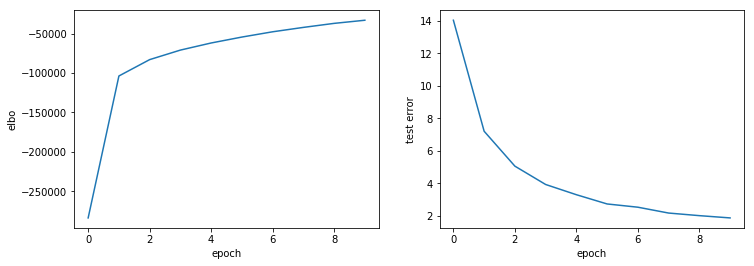

In [52]:
plot_elbos_errs(le_elbos, le_errs)

In [53]:
def train_pytorch(net, train_loader, test_loader, observation_model, num_epochs=50):
    optimizer = torch.optim.Adam(net.parameters(), 1e-3)

    n_train = len(train_loader.sampler)
    n_test = len(test_loader.sampler)
    
    def test():
        with torch.no_grad():
            return 100 * sum(observation_model.error(net(x), y, reduction="sum")
                             for x, y in iter(test_loader)) / n_test

    losses = []
    test_errs = [test()]
    for _ in range(num_epochs):
        total_loss = 0.
        for x, y in iter(train_loader):
            optimizer.zero_grad()
            preds = net(x)
            ll = observation_model.log_likelihood(preds, y, reduction="sum")
            # standard normal prior
            nlp = 0.5 * x.size(0) * sum(p.pow(2).sum() for p in net.parameters()) / n_train
            loss = nlp - ll
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        losses.append(total_loss)
        with torch.no_grad():
            test_errs.append(test())
    return losses, test_errs

In [65]:
try:
    lenet.load_state_dict(torch.load("lenet_params.pt"))
except FileNotFoundError:
    lenet_losses, lenet_test_errs = train_pytorch(lenet, mnist_train_loader_img,
                                                  mnist_test_loader_img, cat_observation_model)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(lenet_losses)
    ax2.plot(lenet_test_errs)
    torch.save(lenet.state_dict(), "lenet_params.pt")

In [57]:
pyro.clear_param_store()
lenet_bnn_pretrained = bayesianize(
    lenet,
    cat_observation_model,
    prior=ezbnn.priors.IIDPrior(dist.Normal(0., 1.)),  # LayerwiseNormalPrior("radford"),
    init_loc_fn=ezbnn.guides.SitewiseInitializer.from_net(lenet, prefix="net"),
    init_scale=.3,
    train_loc=False
)
pretrained_elbos, pretrained_errs = fit_bnn_mnist(lenet_bnn_pretrained, 10)

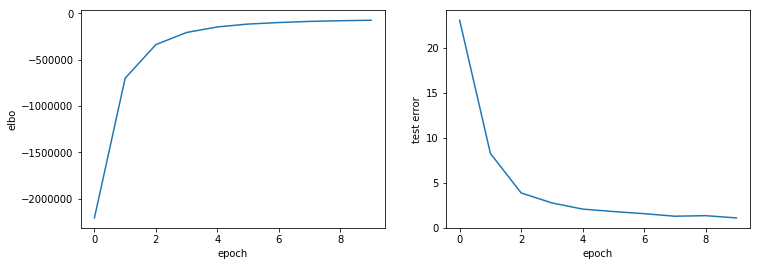

In [58]:
plot_elbos_errs(pretrained_elbos, pretrained_errs)

In [59]:
dummy_x, dummy_y = torch.randn(1, 1, 28, 28), torch.randint(10, size=(1,))
tr = pyro.poutine.trace(lenet_bnn_pretrained.guide).get_trace(dummy_x, dummy_y)
locs = [tr.nodes[node]["fn"].base_dist.loc for node in tr.stochastic_nodes]

In [60]:
all(l.eq(p).all() for l, p in zip(locs, lenet.parameters()))

True

In [ ]:
pyro.clear_param_store()
lenet_bnn_pretrained_tiny_scale = bayesianize(
    lenet,
    cat_observation_model,
    prior=ezbnn.priors.IIDPrior(dist.Normal(0., 1.)),  # LayerwiseNormalPrior("radford"),
    init_loc_fn=ezbnn.guides.SitewiseInitializer.from_net(lenet, prefix="net"),
    init_scale=1e-2,
    train_loc=False
)
pretrained_elbos_tiny, pretrained_errs_tiny = fit_bnn_mnist(lenet_bnn_pretrained_tiny_scale, 50)

In [ ]:
plot_elbos_errs(pretrained_elbos_tiny, pretrained_errs_tiny)

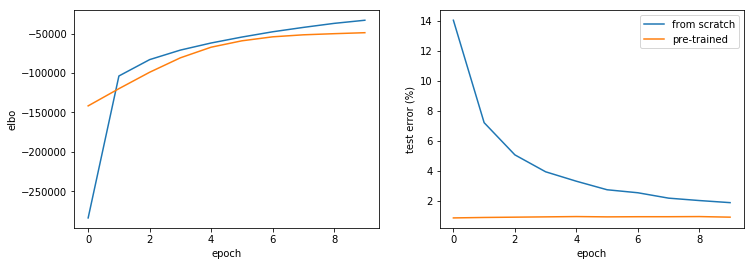

In [83]:
import numpy as np
plot_elbos_errs(
    np.array([le_elbos, pretrained_elbos_tiny]).T,
    np.array([le_errs, pretrained_errs_tiny]),
    ["from scratch", "pre-trained"])
plt.savefig("pretrained_mnist.png")